# Macroeconomic dashboard

Alex Wellman, October 2023

# European Functions

Import Packages

In [96]:
# Import packages

import pandas as pd
import requests
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt

Fetching and Standardizing Data - Function

In [97]:
# Fetch the data

def fetch_EU_data(base_url, wanted_data, countries, dataset_key, datasets_dict, frequency):

    """
    Fetches and processes data for a given set of European countries from a specified URL.

    Parameters:
    base_url (str): The base URL to which the data-specific part will be appended.
    wanted_data (str): URL that specifies data and filters.
    countries (dict): A dictionary with country codes as keys and country names as values.
    dataset_key (str): A key to identify the dataset in the datasets dictionary.
    datasets_dict (dict): A dictionary to store the processed data.
    frequency (str): The frequency of the data ('Q' for quarterly, 'M' for monthly, 'A' for annual).

    The function creates a DataFrame and iterates over each country, fetching data from the constructed URL.
    It processes the data by handling missing values, formatting dates, and converting data types.
    The final dataset is stored in the datasets_dict using the provided dataset_key.

    Returns:
    None: The function does not return anything. It updates the datasets_dict directly.
    """

    # Create an empty DataFrame to store the results
    df_collect = pd.DataFrame()

    # Loop through the countries and extract data
    for country_code, country_name in countries.items():
        # Format the URL with the country code
        url = base_url + wanted_data.format(country_code=country_code)
        response = requests.get(url)

        # Check if the data is found for the country
        if response.status_code != 200:
            print(f"Data not found for {country_name} ({country_code}). Adding empty column.")
            df_collect[country_name] = np.nan
            continue

        df_country = pd.read_csv(StringIO(response.text), sep='\t')

        # Drop rows at the start where all entries are NaN
        df_country = df_country.dropna(how='all').reset_index(drop=True)

        # Check if DataFrame is empty after dropping NaN rows
        if df_country.empty:
            print(f"All data for {country_name} ({country_code}) are empty. Adding empty column.")
            df_collect[country_name] = np.nan
            continue

        # Select the data column assuming it's the second one
        data_columns = df_country.columns[1:]

        # Append the data for the current country to the main DataFrame
        df_collect[country_name] = df_country[data_columns].iloc[0]

    # Replace ':' and any trailing spaces with NaN for missing values
    df_collect.replace(': ?', pd.NA, regex=True, inplace=True)

    # Ensure that the index is a string and strip any whitespace that might cause parsing issues
    df_collect.index = df_collect.index.astype(str).str.strip()

    # Convert index to DateTime
    if frequency == 'Q':
        df_collect.index = pd.PeriodIndex(df_collect.index, freq='Q').to_timestamp()
    elif frequency == 'M':
        df_collect.index = pd.PeriodIndex(df_collect.index, freq='M').to_timestamp()
    elif frequency == 'A':
        df_collect.index = pd.PeriodIndex(df_collect.index, freq='A').to_timestamp()


    # Replace '<NA>' with np.nan and remove ' p' from the data
    df_collect = df_collect.replace({ '<NA>': np.nan, ' p': '' }, regex=True)

    # Convert the index to a datetime format if it's not already
    df_collect.index = pd.to_datetime(df_collect.index)

    # Filter the DataFrame to include data from 1995 onwards
    df_collect = df_collect[df_collect.index.year >= 1995]

    # Convert all data to numeric, coercing errors to NaN
    for column in df_collect.columns:
        df_collect[column] = pd.to_numeric(df_collect[column], errors='coerce')

    # Resample to annual frequency
    if frequency in ['Q', 'M']:
        # Define how to aggregate based on column name
        def aggregate_func(col):
            if dataset_key == "Gross domestic product at market prices":
                return col.sum()
            else:
                return col.mean()
        # Resample using the custom aggregation function
        df_collect = df_collect.resample('A').apply(aggregate_func)

    # Extract year from datetime index and set it as the index
    df_collect.index = pd.to_datetime(df_collect.index.year, format='%Y')


    # Save the final dataset
    datasets_dict[dataset_key] = df_collect

Manipulating Data - Function

In [98]:
# Manipulate the data

data_manipulations = {
    'yoy_change': lambda df: df.pct_change(periods=12) * 100,
    'log_scale': lambda df: np.log(df)
}

Applying Manipulations - Function

In [99]:
# Apply the manipulation and save the result

def apply_manipulation_and_save(data_key, manipulation_key, result_key, datasets_dict):
    """
    Applies a specified manipulation to data from the datasets dictionary and saves the result under a new key.

    Args:
    data_key (str): The key in the datasets dictionary for the data to be manipulated.
    manipulation_key (str): The key for the manipulation to be applied.
    result_key (str): The key under which to save the manipulated data in the dictionary.
    datasets_dict (dict): The dictionary containing the datasets and manipulations.
    """
    if data_key in datasets_dict and manipulation_key in data_manipulations:
        manipulation_function = data_manipulations[manipulation_key]
        datasets_dict[result_key] = manipulation_function(datasets_dict[data_key])
    else:
        print(f"Data for key {data_key} or manipulation {manipulation_key} not found")

List Available Data - Function

In [100]:
# List the available datasets

def list_dataset_names(datasets_dict):
    """
    Lists the names of all datasets stored in the provided dictionary.

    Args:
    datasets_dict (dict): The dictionary containing the datasets.
    """
    if datasets_dict:
        print("Datasets available:")
        for dataset_name in datasets_dict.keys():
            print(dataset_name)
    else:
        print("No datasets available.")

Plotting - Function

In [101]:
# plot the data

def plot_dataset(datasets_dict, dataset_key, title, x_label, y_label):
    """
    Plots a specified dataset from the datasets dictionary over time by country.

    Args:
    datasets_dict (dict): The dictionary containing the datasets.
    dataset_key (str): The key for the dataset to be plotted.
    title (str): The title of the plot.
    x_label (str): The label for the x-axis.
    y_label (str): The label for the y-axis.
    """
    if dataset_key in datasets_dict:
        df = datasets_dict[dataset_key]

        plt.figure(figsize=(14, 7))
        for country in df.columns:
            plt.plot(df.index, df[country], label=country)

        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Dataset '{dataset_key}' not found in the dictionary.")


Table - Function

In [102]:
# Create a table of country statistics

def create_country_stats_table(datasets_dict, dataset_key):
    # Check if the dataset key exists in the dictionary
    if dataset_key not in datasets_dict:
        print(f"Dataset key '{dataset_key}' not found in the dictionary.")
        return None

    # Get the dataset from the dictionary
    df = datasets_dict[dataset_key]

    # Initialize a list to hold the rows for the table
    rows = []

    # Iterate through each country in the dataset
    for country in df.columns:
        # Skip if the column is the index
        if country == df.index.name:
            continue

        # Latest non-null value and its date
        latest_data = df[country].dropna()
        if not latest_data.empty:
            latest_value = latest_data.iloc[-1]
            latest_date = latest_data.index[-1]
        else:
            latest_value, latest_date = np.nan, pd.NaT

        # Ensure latest_date is a datetime-like object
        latest_date = df.index.max()
        if not isinstance(latest_date, pd.Timestamp):
            print(f"Warning: Latest date for {country} is not a datetime object: {latest_date}")
            continue  # Skip this country if latest_date is not valid

        # Previous year's value and its date
        prev_year_date = latest_date - pd.DateOffset(years=1)
        prev_year_value = df[country][df.index == prev_year_date]
        prev_year_value = prev_year_value.iloc[0] if not prev_year_value.empty else np.nan

        # Append the data as a new row
        rows.append({'Country': country, 'Latest Value': latest_value,
                     'Date of Latest Value': latest_date,
                     'Previous Year Value': prev_year_value,
                     'Date of Previous Year Value': prev_year_date})

    # Create a DataFrame from the rows
    table = pd.DataFrame(rows)

    return table

## **Euro Data**

**Specify countries and initialize dic.**

In [103]:
euro_data = {}

countries = {
    'FR': 'France',
    'DE': 'Germany',
    'IT': 'Italy',
    'EA': 'Euro Area',
    'UK': 'UK',
    'ES': 'Spain',
    'NL': 'Netherlands',
}

**Pull the data and put into the dic**

In [104]:
base_url = "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/" #don't change this


fetch_EU_data(base_url, "gov_10q_ggdebt/Q.GD.S13.PC_GDP.{country_code}?format=TSV", countries, "Debt % of GDP", euro_data, 'Q')

fetch_EU_data(base_url, "nasa_10_nf_tr/A.CP_MNAC.PAID.D41.S13.{country_code}?format=TSV", countries, "General Goverment Interest Paid", euro_data, 'A')

fetch_EU_data(base_url, "namq_10_gdp/Q.CP_MNAC.NSA.B1GQ.{country_code}?format=TSV", countries, "Gross domestic product at market prices", euro_data, 'Q')

fetch_EU_data(base_url, "nasa_10_nf_tr/A.CP_MNAC.RECV.B9.S13.{country_code}?format=TSV", countries, "Net lending (+) /net borrowing (-)", euro_data, 'A')

fetch_EU_data(base_url, "ei_lmhr_m/M.PC_ACT.SA.LM-UN-T-LE25.{country_code}?format=TSV", countries, "Youth Unemployment Rate", euro_data, 'M')

fetch_EU_data(base_url, "namq_10_lp_ulc/Q.I10.SCA.RLPR_HW.{country_code}?format=TSV", countries, "Labor Productivity Per Hour Worked", euro_data, 'Q')

fetch_EU_data(base_url, "namq_10_lp_ulc/Q.I10.SCA.RLPR_Per.{country_code}?format=TSV", countries, "Labor Productivity Per Person Employed", euro_data, 'Q')

fetch_EU_data(base_url, "ei_lmhr_m/M.PC_ACT.SA.LM-UN-T-TOT.{country_code}?format=TSV", countries, "Overall Unemployment Rate", euro_data, 'M')

fetch_EU_data(base_url, "prc_hicp_midx/M.I05.CP00.{country_code}?format=TSV", countries, "HICP", euro_data, 'M')

fetch_EU_data(base_url, "namq_10_gdp/Q.CLV_I05.NSA.B1G.{country_code}?format=TSV", countries, "Value Added", euro_data, 'Q')

fetch_EU_data(base_url, "earn_ses_monthly/A.B-N.TOTAL.TOTAL.TOTAL.T.MEAN_E_EUR.{country_code}?format=TSV", countries, "Mean earnings, Business economy", euro_data, 'A')

fetch_EU_data(base_url, "earn_ses_hourly/A.B-N.OC2.FT.TOTAL.T.MED_E_EUR.{country_code}?format=TSV", countries, "Hourly Earn", euro_data, 'A')




Data not found for Euro Area (EA). Adding empty column.
Data not found for UK (UK). Adding empty column.
Data not found for Euro Area (EA). Adding empty column.
Data not found for Euro Area (EA). Adding empty column.
Data not found for Euro Area (EA). Adding empty column.
Data not found for Euro Area (EA). Adding empty column.
Data not found for Euro Area (EA). Adding empty column.
Data not found for Euro Area (EA). Adding empty column.


**Apply data manipulations and save as new entry in dic**

In [105]:
apply_manipulation_and_save("Youth Unemployment Rate", "yoy_change", "Youth Unemployment Rate YOY", euro_data)
apply_manipulation_and_save("HICP", "yoy_change", "HICP YOY Change", euro_data)

In [106]:
# Example of more complex manipulation

# Access the datasets
dataset1 = euro_data.get('Youth Unemployment Rate YOY')
dataset2 = euro_data.get('Youth Unemployment Rate YOY')

multiplied = dataset1 * dataset2

 # Perform division
divided = dataset1 / dataset2

# Save the results back to the dictionary
# euro_data['multiplied_result'] = multiplied
# euro_data['divided_result'] = divided


Policy Note Data Sets

In [107]:
# Adjust units
euro_data['Gross domestic product at market prices'] = euro_data.get('Gross domestic product at market prices') / 1000
euro_data['Net lending (+) /net borrowing (-)'] = euro_data.get('Net lending (+) /net borrowing (-)') / 1000
euro_data['General Goverment Interest Paid'] = euro_data.get('General Goverment Interest Paid') / 1000

num = euro_data.get('General Goverment Interest Paid')
denom = euro_data.get('Gross domestic product at market prices')
euro_data['Interest to Debt']= (num/denom)*100

**List available datasets**

In [108]:
list_dataset_names(euro_data)


Datasets available:
Debt % of GDP
General Goverment Interest Paid
Gross domestic product at market prices
Net lending (+) /net borrowing (-)
Youth Unemployment Rate
Labor Productivity Per Hour Worked
Labor Productivity Per Person Employed
Overall Unemployment Rate
HICP
Value Added
Mean earnings, Business economy
Hourly Earn
Youth Unemployment Rate YOY
HICP YOY Change
Interest to Debt


**Plot Data**

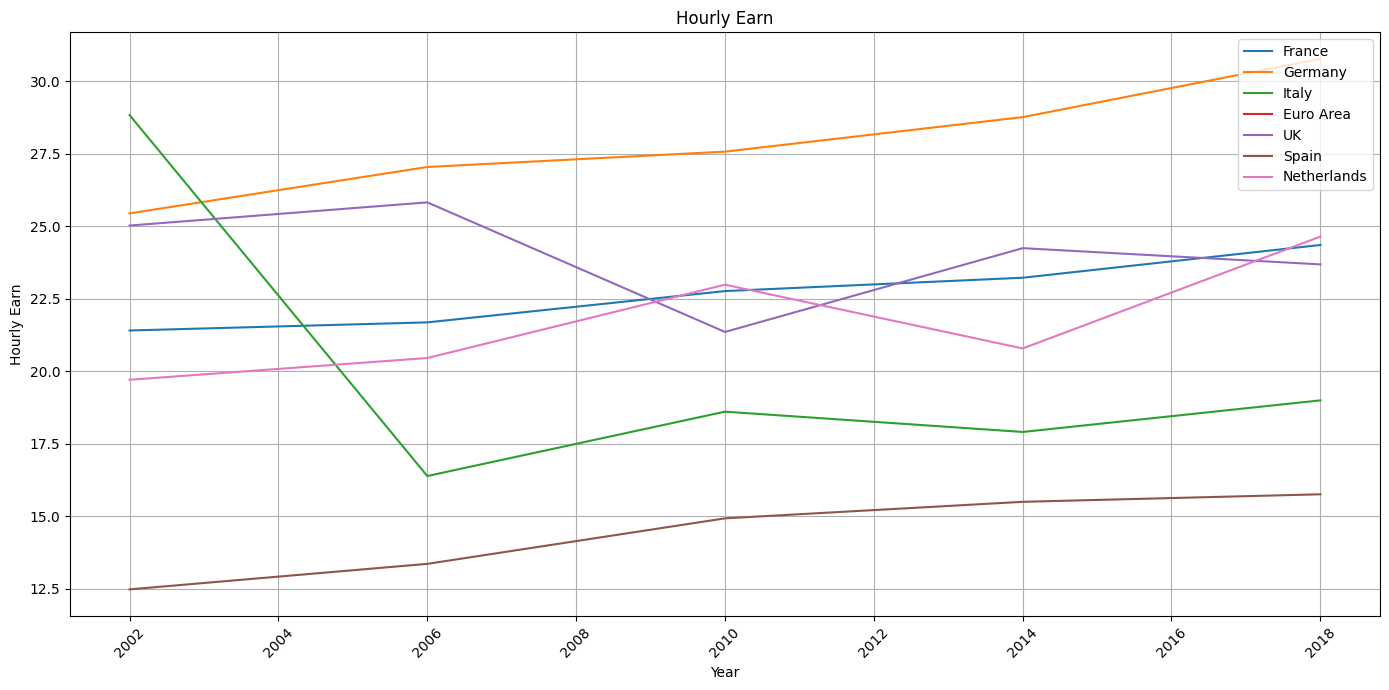

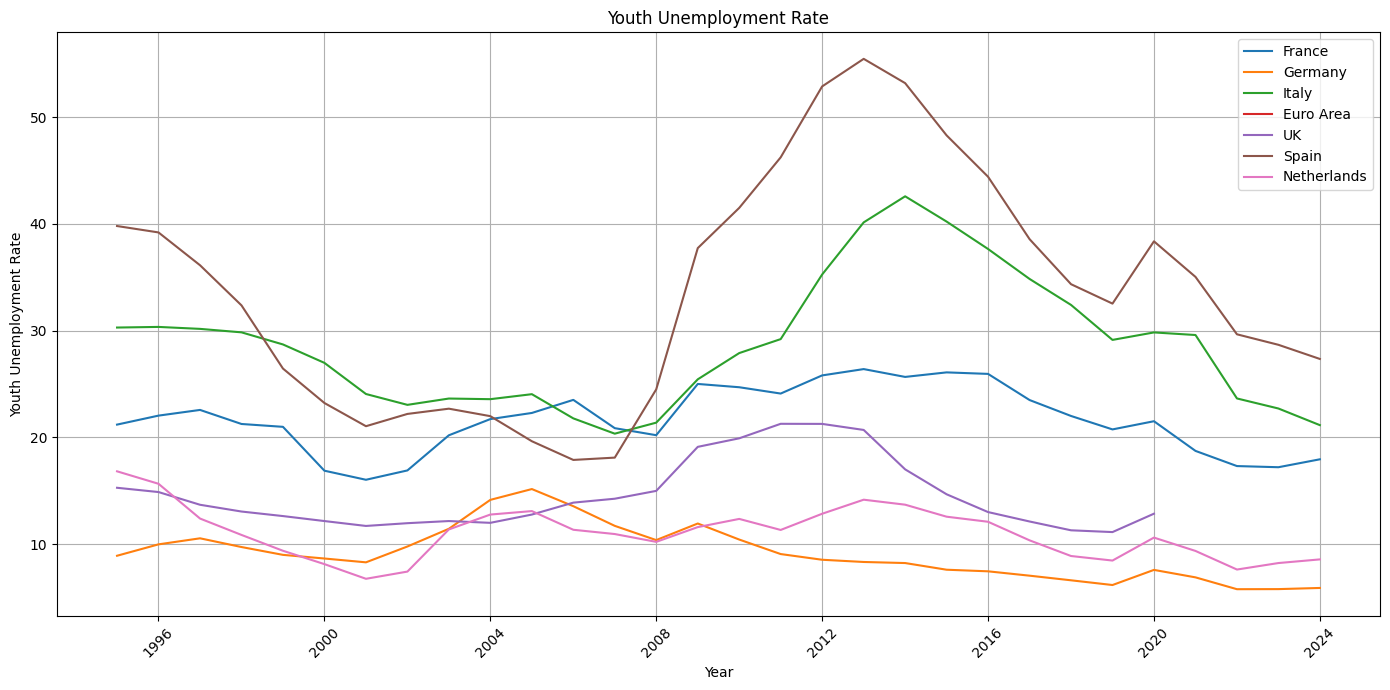

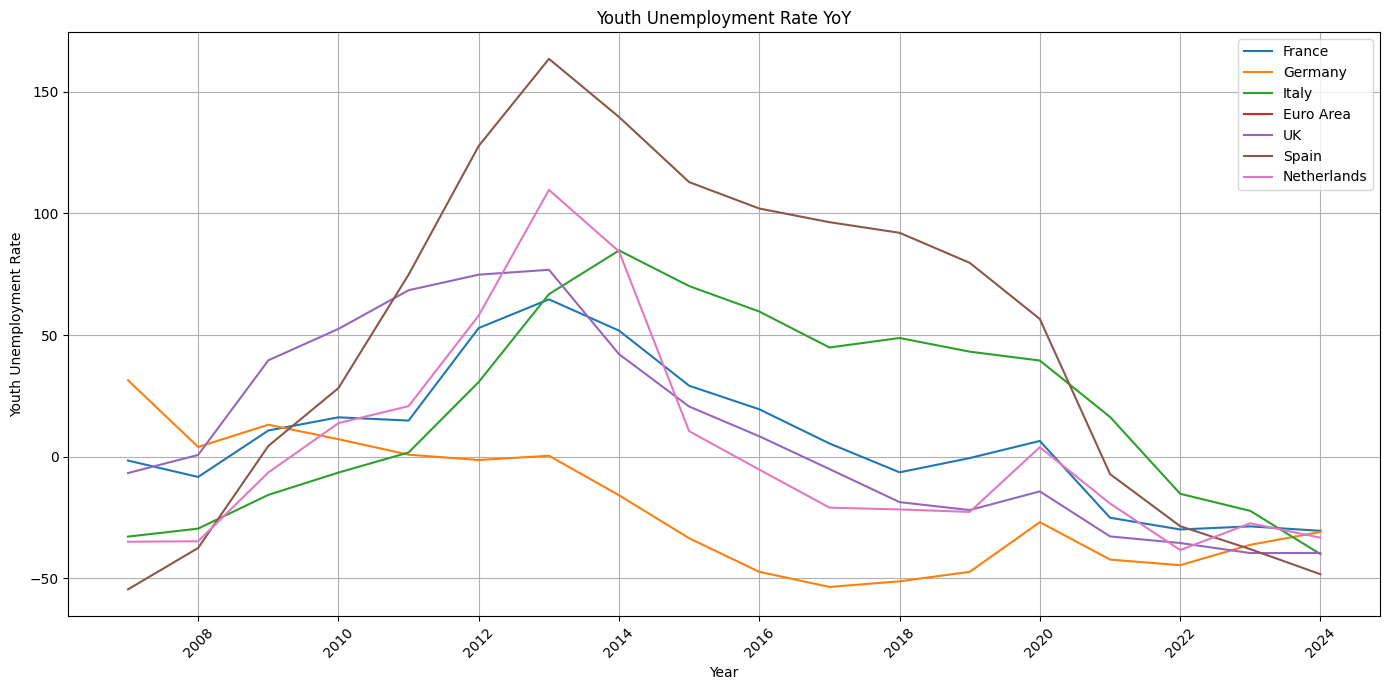

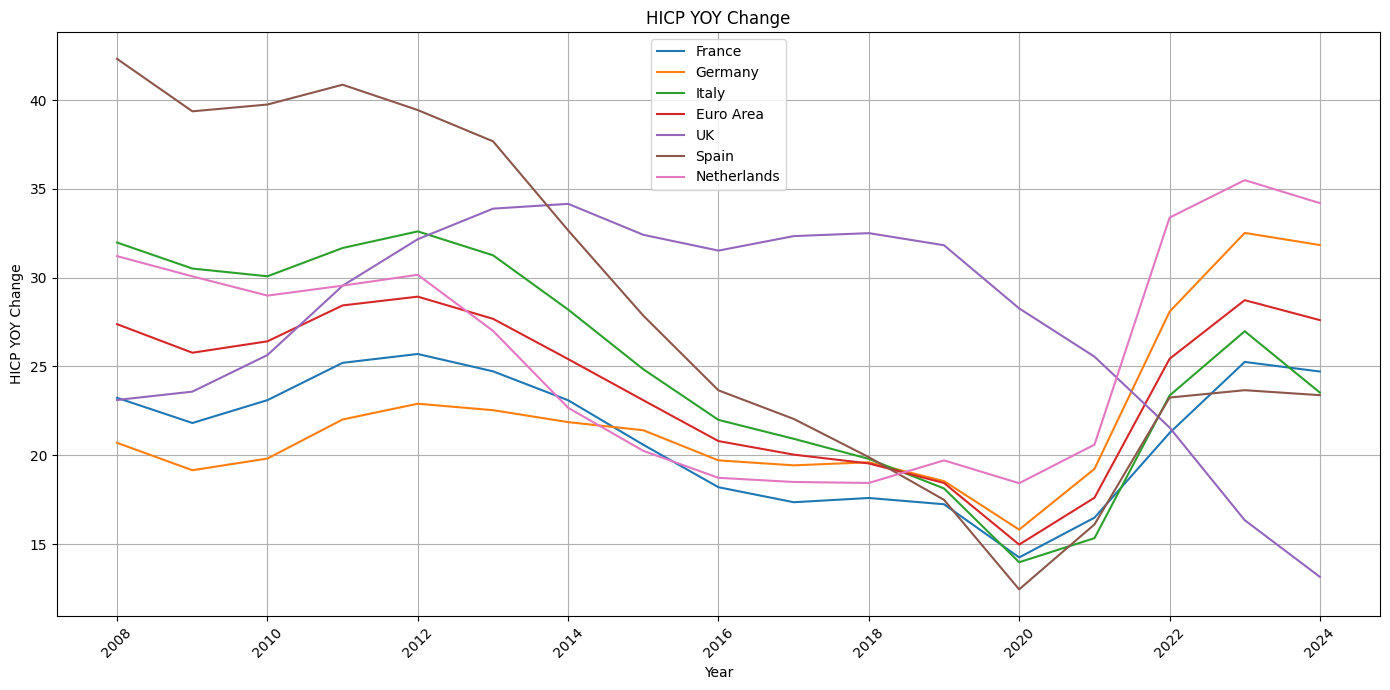

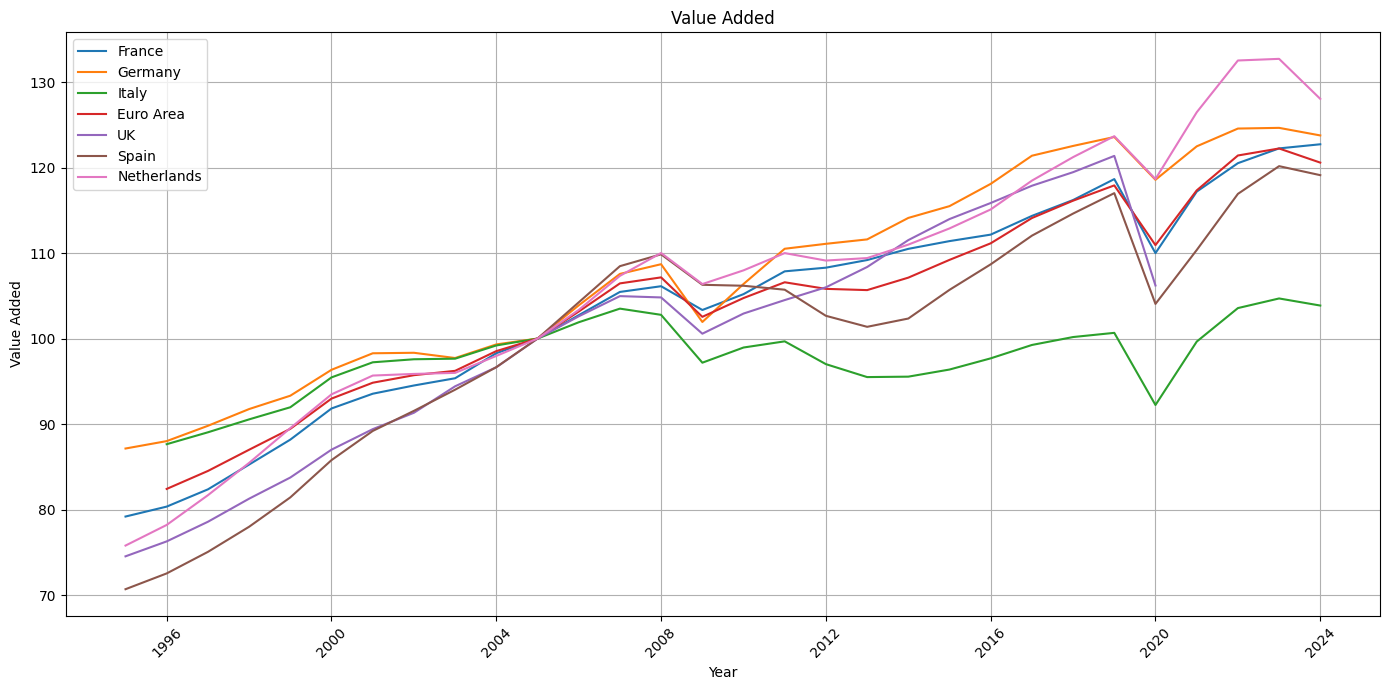

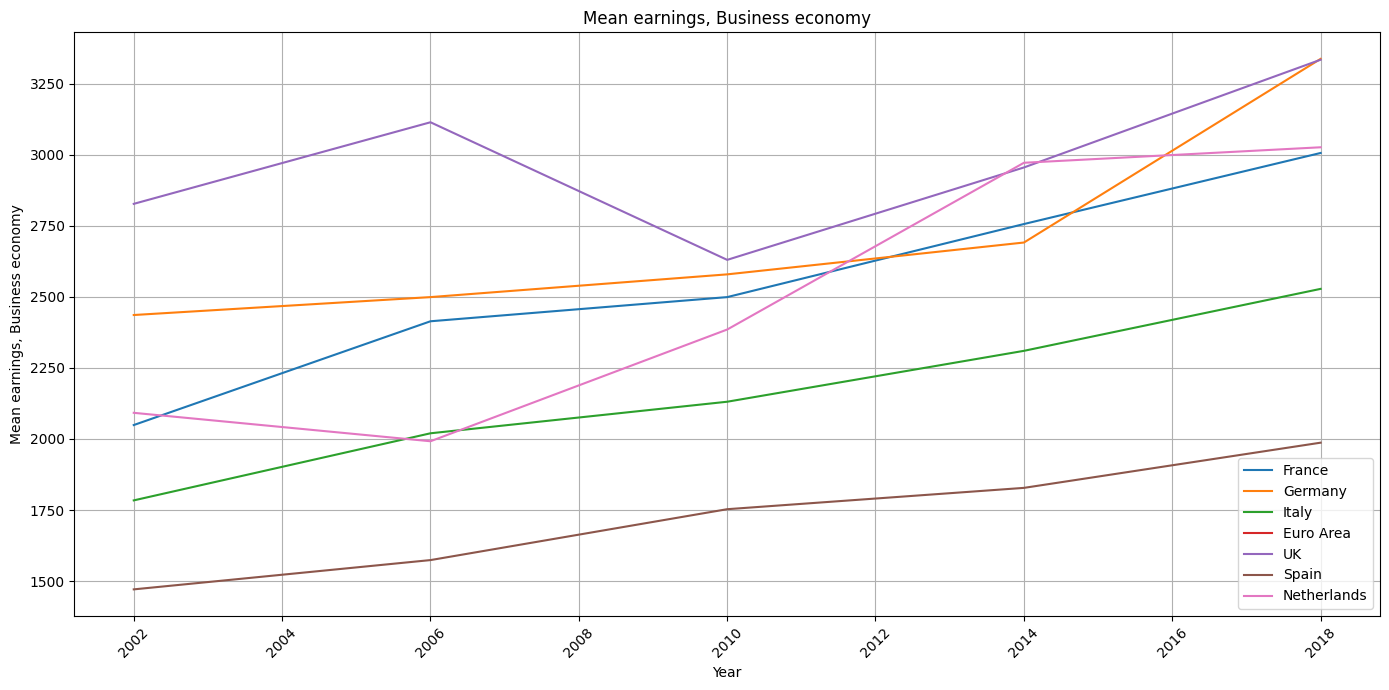

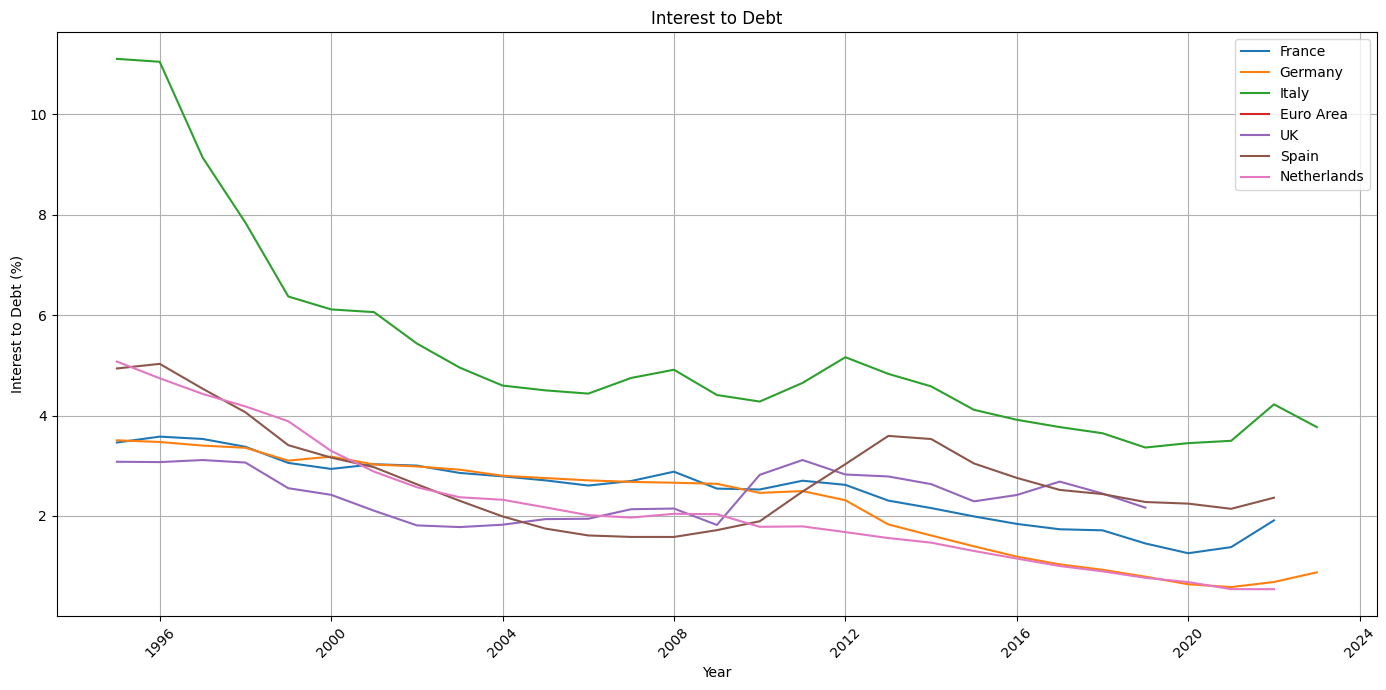

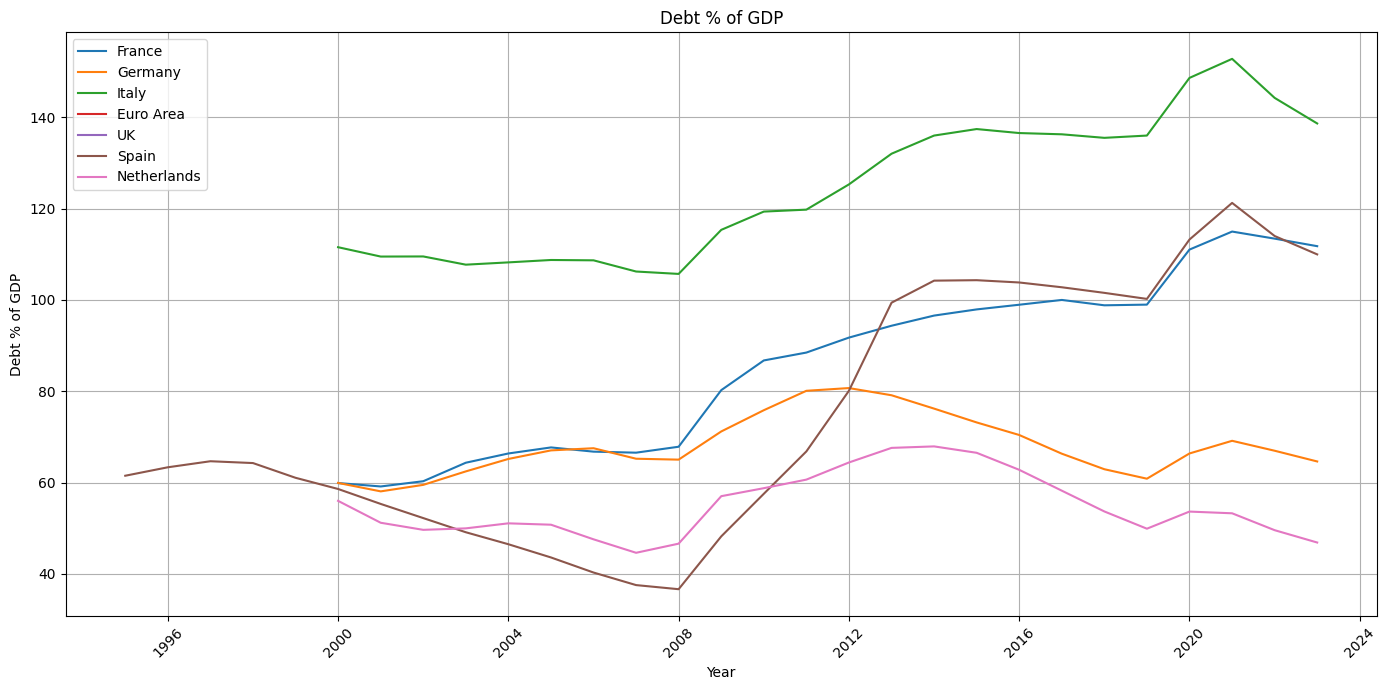

In [109]:
plot_dataset(euro_data, 'Hourly Earn', 'Hourly Earn', 'Year', 'Hourly Earn')
plot_dataset(euro_data, 'Youth Unemployment Rate', 'Youth Unemployment Rate', 'Year', 'Youth Unemployment Rate')
plot_dataset(euro_data, 'Youth Unemployment Rate YOY', 'Youth Unemployment Rate YoY', 'Year', 'Youth Unemployment Rate')
plot_dataset(euro_data, 'HICP YOY Change', 'HICP YOY Change', 'Year', 'HICP YOY Change')
plot_dataset(euro_data, 'Value Added', 'Value Added', 'Year', 'Value Added')
plot_dataset(euro_data, 'Mean earnings, Business economy', 'Mean earnings, Business economy', 'Year', 'Mean earnings, Business economy')

plot_dataset(euro_data, 'Interest to Debt', 'Interest to Debt', 'Year', 'Interest to Debt (%)')
plot_dataset(euro_data, 'Debt % of GDP' , 'Debt % of GDP', 'Year', 'Debt % of GDP')



**Create Table**

In [110]:
create_country_stats_table(euro_data,'Youth Unemployment Rate YOY')


,Country,Latest Value,Date of Latest Value,Previous Year Value,Date of Previous Year Value
0,France,-30.448821,2024-01-01,-28.620809,2023-01-01
1,Germany,-30.926829,2024-01-01,-36.179982,2023-01-01
2,Italy,-40.014181,2024-01-01,-22.253923,2023-01-01
3,Euro Area,NaN,2024-01-01,NaN,2023-01-01
4,UK,-39.550679,2024-01-01,-39.574357,2023-01-01
5,Spain,-48.274232,2024-01-01,-37.977650,2023-01-01
6,Netherlands,-33.268482,2024-01-01,-27.352941,2023-01-01


In [111]:
create_country_stats_table(euro_data,'HICP YOY Change')


,Country,Latest Value,Date of Latest Value,Previous Year Value,Date of Previous Year Value
0,France,24.716641,2024-01-01,25.255605,2023-01-01
1,Germany,31.841410,2024-01-01,32.523435,2023-01-01
2,Italy,23.531164,2024-01-01,26.985057,2023-01-01
3,Euro Area,27.612253,2024-01-01,28.735819,2023-01-01
4,UK,13.149109,2024-01-01,16.341848,2023-01-01
5,Spain,23.384749,2024-01-01,23.664024,2023-01-01
6,Netherlands,34.202922,2024-01-01,35.496333,2023-01-01
